# GoBike Explanatory Analysis

### by Chloe Xue &nbsp; &nbsp; July, 2019

## Investigation Overview
In this investigation, I want to look at the trends of bike trips, target on the major user group to figure out demand and the user behaviors on time preference. 

## Dataset Overview
In this investigation, I want to look at the trends of bike trips, target on the major user group to figure out demand and the user behaviors on time preference. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os 
import glob
import math

%matplotlib inline

In [2]:
df = pd.read_csv('gobike_explore.csv')

In [3]:
color = "Blues"
sb.set_style("whitegrid")

day_of_week = {'start_time_day':['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']}
for day in day_of_week:
    ordered_day = pd.api.types.CategoricalDtype(ordered = True,categories = day_of_week[day])
    df[day] = df[day].astype(ordered_day)

In [4]:
df['age'] = df['age'].replace(0, np.nan).replace('\.0', '', regex=True)

df['age_bins'] = df['age'].apply(lambda x: '10 - 20' if 10<=x<=20
                                 else '20 - 30' if 20<x<=30
                                 else '30 - 40' if 30<x<=40
                                 else '40 - 50' if 40<x<=50
                                 else '50 - 60' if 50<x<=60
                                 else '60 - 80' if 60<x<=80
                                 else '80+' if 80<x
                                 else x)

### Daily Trend of Trips
Numbers of bike-sharing trips can fluctuate sharply within one month. The overall trend tend to be steady in numbers in the past 12 months except there are huge dropdown in December 2018 and January 2019. The recent peak happens on April 2019. Numbers are dropping in May and fluctuate sharply on a weekly basis.

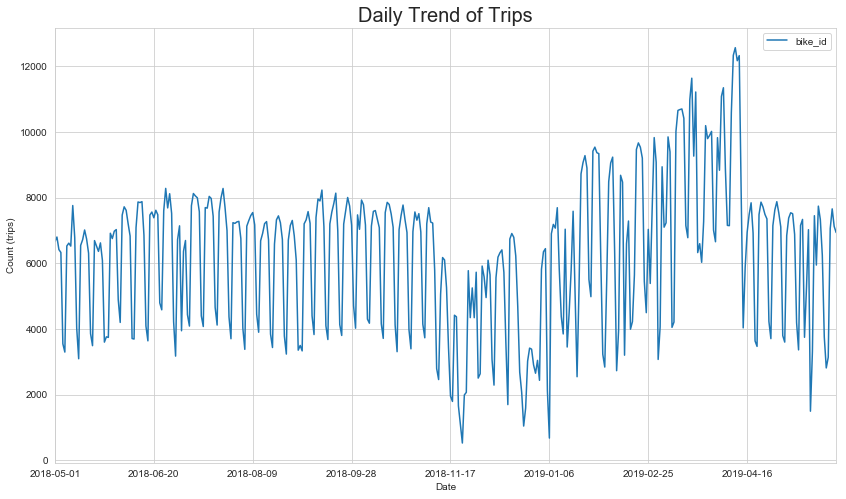

In [5]:
df.groupby('start_time_date').agg({'bike_id':'count'}).plot(kind='line',figsize = (14,8))
plt.title('Daily Trend of Trips', fontsize = 20)
plt.xlabel('Date')
plt.ylabel('Count (trips)')
plt.show()

### Monthly Trend of Trips
If we dig into monthly trend distribution, we can see GoBike service shows a seasonality. It is lessly used in winter and more used in spring. November and December have lowest number of trips, March and April have most number of trips. Winter is San Francisco is cold, while spring has the most comfortable weather on bike riding.

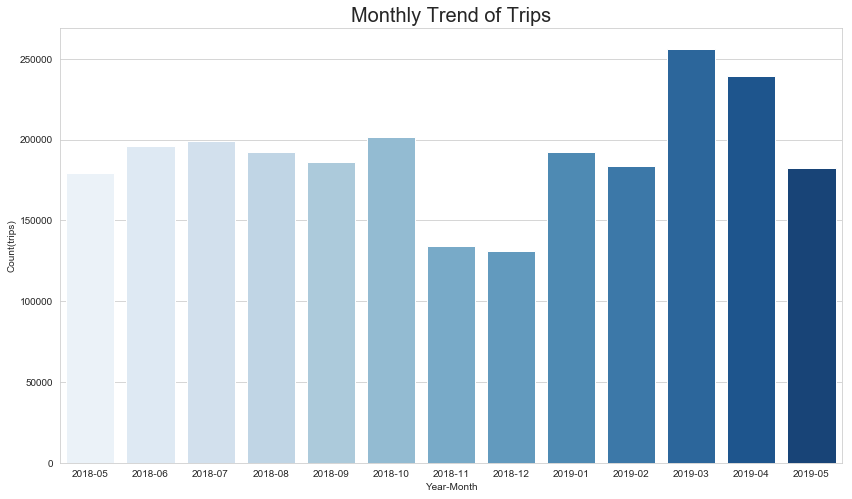

In [6]:
# Plot monthly count of trips.
plt.figure(figsize = (14,8))
sb.countplot(x = 'start_time_year_month', palette = color, 
             data = df.sort_values(by = 'start_time_year_month'))
plt.title('Monthly Trend of Trips', fontsize = 20)
plt.xlabel('Year-Month')
plt.ylabel('Count(trips)')
plt.show()

### Trip Proportion by User Type
If we break down the user group of GoBike service, we can see that the main user group for bike renting is Subscriber which takes 85.6% of trips. Customer takes 14.4% of trips.

In [7]:
# Compute the proportion of trips count for each group.
customer_proportion = df.query('user_type == "Customer"')['bike_id'].count()/df['bike_id'].count()
subscriber_proportion = df.query('user_type == "Subscriber"')['bike_id'].count()/df['bike_id'].count()

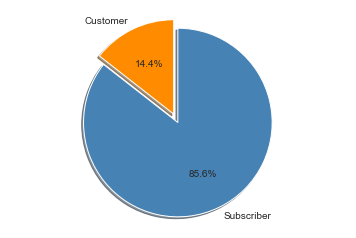

In [8]:
labels = ['Customer', 'Subscriber']
sizes = [customer_proportion, subscriber_proportion]
colors = ['darkorange', 'steelblue']
explode = (0, 0.1)

plt.pie(sizes, explode=explode, labels=labels, colors = colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.show()

### Trip Duration by User Type
Curious to know how long the users ride bikes on each trip? Surprisingly, though subscriber group takes 85% of the trips, the average duration is only 11.16 minutes. Comparing to it, average duration of trips for customer group is much higher, which is 28.6 minutes. Average trip duration is less than 30 minutes actually makes sense because individual trip is free up to 30 minutes.

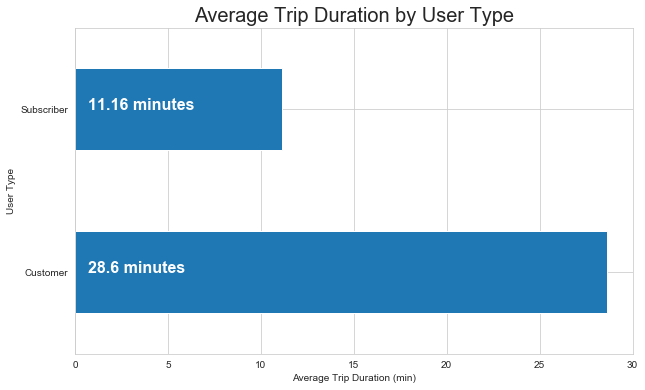

In [9]:
# Plot average trip duration time on each group.
duration_user_type = df.groupby('user_type')['duration'].mean().reset_index()
ax = df.groupby('user_type')['duration'].mean().plot(kind = 'barh', figsize = (10,6))
ax.set_title('Average Trip Duration by User Type', fontsize = 20)
ax.set_xlabel('Average Trip Duration (min)')
ax.set_ylabel('User Type')


for i,j in enumerate(duration_user_type["duration"]):
    ax.text(.7,i,str(round(j,2))+' minutes', weight='bold', ha='left', fontsize=16, color="white")

plt.show()

In [10]:
customer_hour_sub = df.loc[(df.user_type == 'Customer') & (df['start_time_hour'] >= 6) & (df['start_time_hour'] <= 22)]
subscriber_hour_sub = df.loc[(df.user_type == 'Subscriber') & (df['start_time_hour'] >= 6) & (df['start_time_hour'] <= 22)]

### Customer/Subscriber - Hourly Trip Distribution on Weekly Basis
Continuing to break down the time distribution on GoBike service by each user group  we can see the customer group most frequently takes bike ride between 12:00 and 17:00 on weekends and at 17:00 on weekdays. 

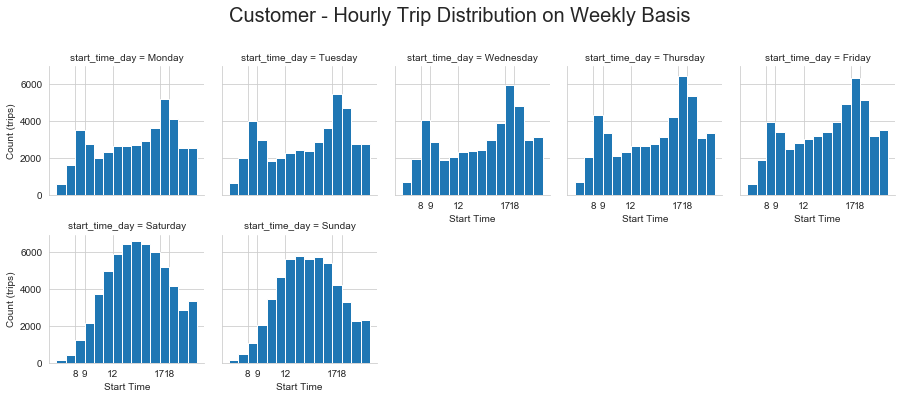

In [11]:
# Plot hourly trip distribution for Customer.
g = sb.FacetGrid(data=customer_hour_sub,col = 'start_time_day',col_wrap = 5, height = 2.5)
g.map(plt.hist,'start_time_hour', bins=np.arange(6,22,1)).set(xticks = [8,9,12,17,18])
g.fig.suptitle('Customer - Hourly Trip Distribution on Weekly Basis', fontsize = 20, y = 1.1)
g.set_xlabels('Start Time')
g.set_ylabels('Count (trips)')
plt.show()

Different from customer group, subscriber group tend to use the service during rush hours 8:00 and 17:00 on weekdays. This behavior implies subscriber user is the group of people use service for communting to work. On the contrary, they are less likely to use the service on Weekends. 

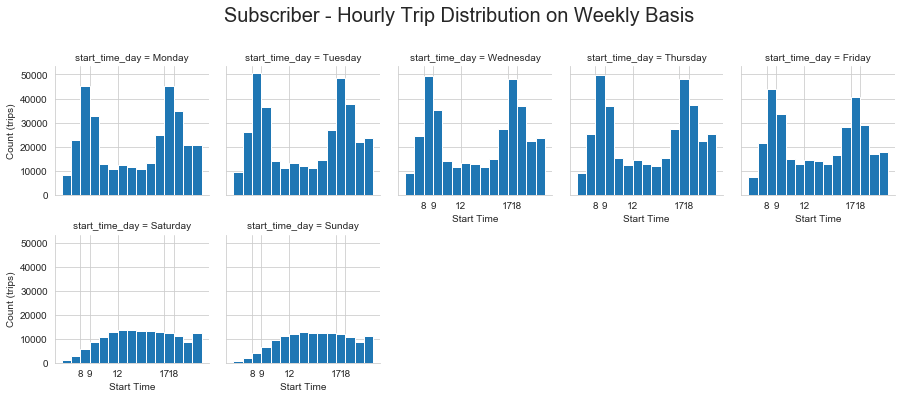

In [12]:
# Plot hourly trip distribution for Subscriber.
g = sb.FacetGrid(data=subscriber_hour_sub,col = 'start_time_day',col_wrap = 5, height = 2.5)
g.map(plt.hist,'start_time_hour', bins=np.arange(6,22,1)).set(xticks = [8,9,12,17,18])
g.fig.suptitle('Subscriber - Hourly Trip Distribution on Weekly Basis', fontsize = 20, y = 1.1)
g.set_xlabels('Start Time')
g.set_ylabels('Count (trips)')
plt.show()

Huge differnce on service proportion usage between two groups shows up on hourly trend as well. Hour preferences for subscriber is under greater variation through a week than customer group.

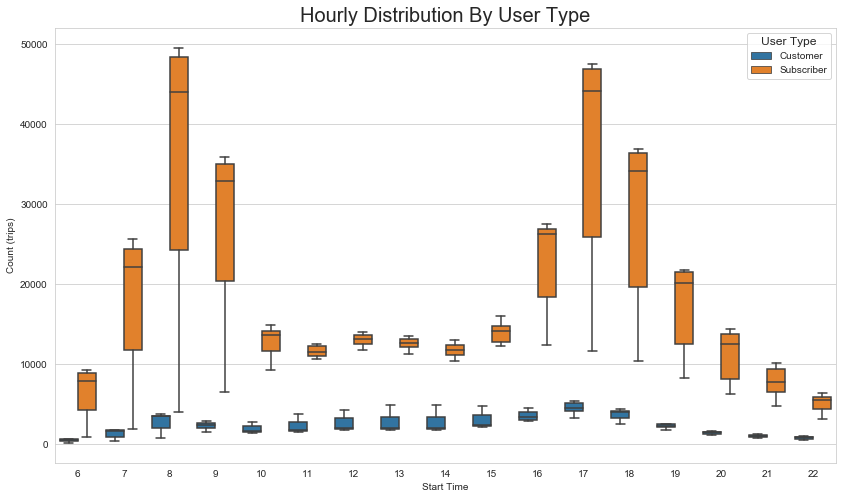

In [13]:
# Create boxplot. 
user_group = df.groupby(['user_type','start_time_day','start_time_hour','member_gender']).bike_id.count().unstack().reset_index()
user_group['count_trip'] = user_group[['Female','Male','Other']].sum(axis=1)
user_group_sub = user_group.loc[(user_group['start_time_hour'] >= 6) & (user_group['start_time_hour'] <= 22)]

fig,axes = plt.subplots(figsize = (14,8),nrows=1,ncols=1)
sb.boxplot(x='start_time_hour', y = 'count_trip', hue = 'user_type',data = user_group_sub)
plt.title('Hourly Distribution By User Type',fontsize = 20)
plt.xlabel('Start Time')
plt.ylabel('Count (trips)')
plt.legend().set_title('User Type', prop = {'size':12})
plt.show()

In [14]:
user_group_age = df.groupby(['age_bins','user_type']).size().reset_index()
user_group_age['percentage']=user_group_age[0]/user_group_age[0].sum()*100

user_group_gender = df.groupby(['member_gender','user_type']).size().reset_index()
user_group_gender['percentage']=user_group_gender[0]/user_group_gender[0].sum()*100

### Age and Gender Distribution by User Type
Who are the major user groups? We can see that male users and people in the age of 20-40 are the target users for GoBike Servie.

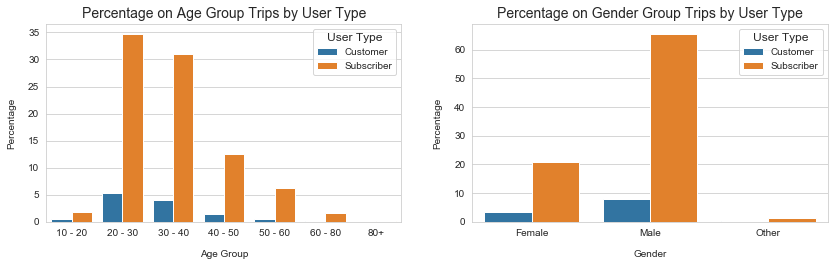

In [15]:
fig, ax = plt.subplots(figsize = (14,8), nrows = 1, ncols = 2)
plt.subplot(221)
ax1 = sb.barplot(data = user_group_age, x = 'age_bins', y='percentage', hue = 'user_type')
ax1.set_title('Percentage on Age Group Trips by User Type', fontsize = 14)
ax1.set_xlabel('Age Group', labelpad = 12)
ax1.set_ylabel('Percentage', labelpad = 12)
ax1.legend().set_title('User Type', prop = {'size':12})

plt.subplot(222)
ax2 = sb.barplot(data = user_group_gender, x = 'member_gender',y='percentage', hue = 'user_type')
ax2.set_title('Percentage on Gender Group Trips by User Type', fontsize = 14)
ax2.set_xlabel('Gender', labelpad = 12)
ax2.set_ylabel('Percentage', labelpad = 12)
ax2.legend().set_title('User Type', prop = {'size':12})

### Timely Frequency by User Type
Is there a certain time of the day attracting most users? For subscribers who tend to ride bikes for commute, 8am and 5pm are the most favored hours. It seems like Friday or Monday is a work-from-home day since the bike usage is the least among weekdays for subscribers. Customers like to ride bikes on weekends during day time or around 5pm during weekdays. Overall, GoBike service has highest demand on 5pm everyday. 

In [16]:
pd.options.mode.chained_assignment = None 

In [17]:
customer_timely = user_group.loc[(user_group.user_type == 'Customer') & (user_group['start_time_hour'] >= 6) & (user_group['start_time_hour'] <= 22)]
customer_timely['count_perc'] = customer_timely['count_trip'].apply(lambda x: (x/customer_timely['count_trip'].sum())*100)
customer_timely['rank'] = customer_timely['count_perc'].rank(ascending=False).astype(int)
customer_plot = customer_timely.pivot_table(index = 'start_time_hour',columns = 'start_time_day', values = 'rank')

subscriber_timely = user_group.loc[(user_group.user_type == 'Subscriber') & (user_group['start_time_hour'] >= 6) & (user_group['start_time_hour'] <= 22)]
subscriber_timely['count_perc'] = subscriber_timely['count_trip'].apply(lambda x: (x/subscriber_timely['count_trip'].sum())*100)
subscriber_timely['rank'] = subscriber_timely['count_perc'].rank(ascending=False).astype(int)
subscriber_plot = subscriber_timely.pivot_table(index = 'start_time_hour',columns = 'start_time_day', values = 'rank')

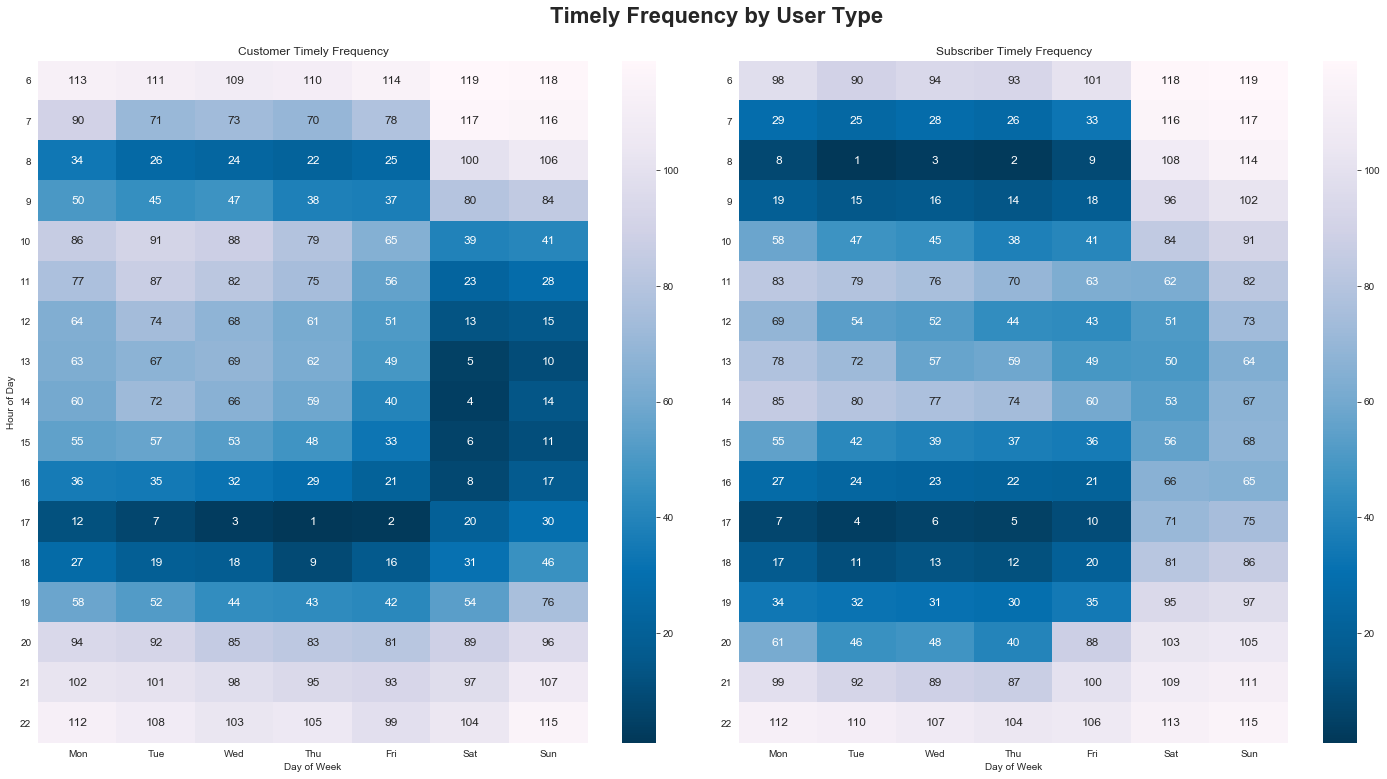

In [18]:
plt.figure(figsize = (20,20))
plt.subplot(221)
plt.suptitle('Timely Frequency by User Type', fontsize = 22, fontweight = 'semibold',y=1.02)
sb.heatmap(customer_plot, fmt='d', annot=True, cmap='PuBu_r', annot_kws={"size": 12})
plt.title('Customer Timely Frequency', y=1.02)
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.xticks(np.arange(0.5, 7.5,1), ('Mon', 'Tue', 'Wed', 'Thu', 'Fri','Sat','Sun'))
plt.yticks(rotation = 360)

plt.subplot(222)
sb.heatmap(subscriber_plot, fmt='d', annot=True, cmap='PuBu_r', annot_kws={"size": 12})
plt.title('Subscriber Timely Frequency', y=1.02)
plt.xlabel('Day of Week')
plt.ylabel(' ')
plt.xticks(np.arange(0.5, 7.5,1), ('Mon', 'Tue', 'Wed', 'Thu', 'Fri','Sat','Sun'))
plt.yticks(rotation = 360)
plt.tight_layout()
plt.show()

### Top 20 Most Frequent Stations
What are the popular locations people like to ride the bikes? People ride bikes in city area around train stations, ferry stations and SOMA area. SOMA area is home to many of city’s museums, and headquarters of several major software and internet companies. Those locations are convenient for commuting to work, touring for attractions such as museums, ferries, bars and restaurants.

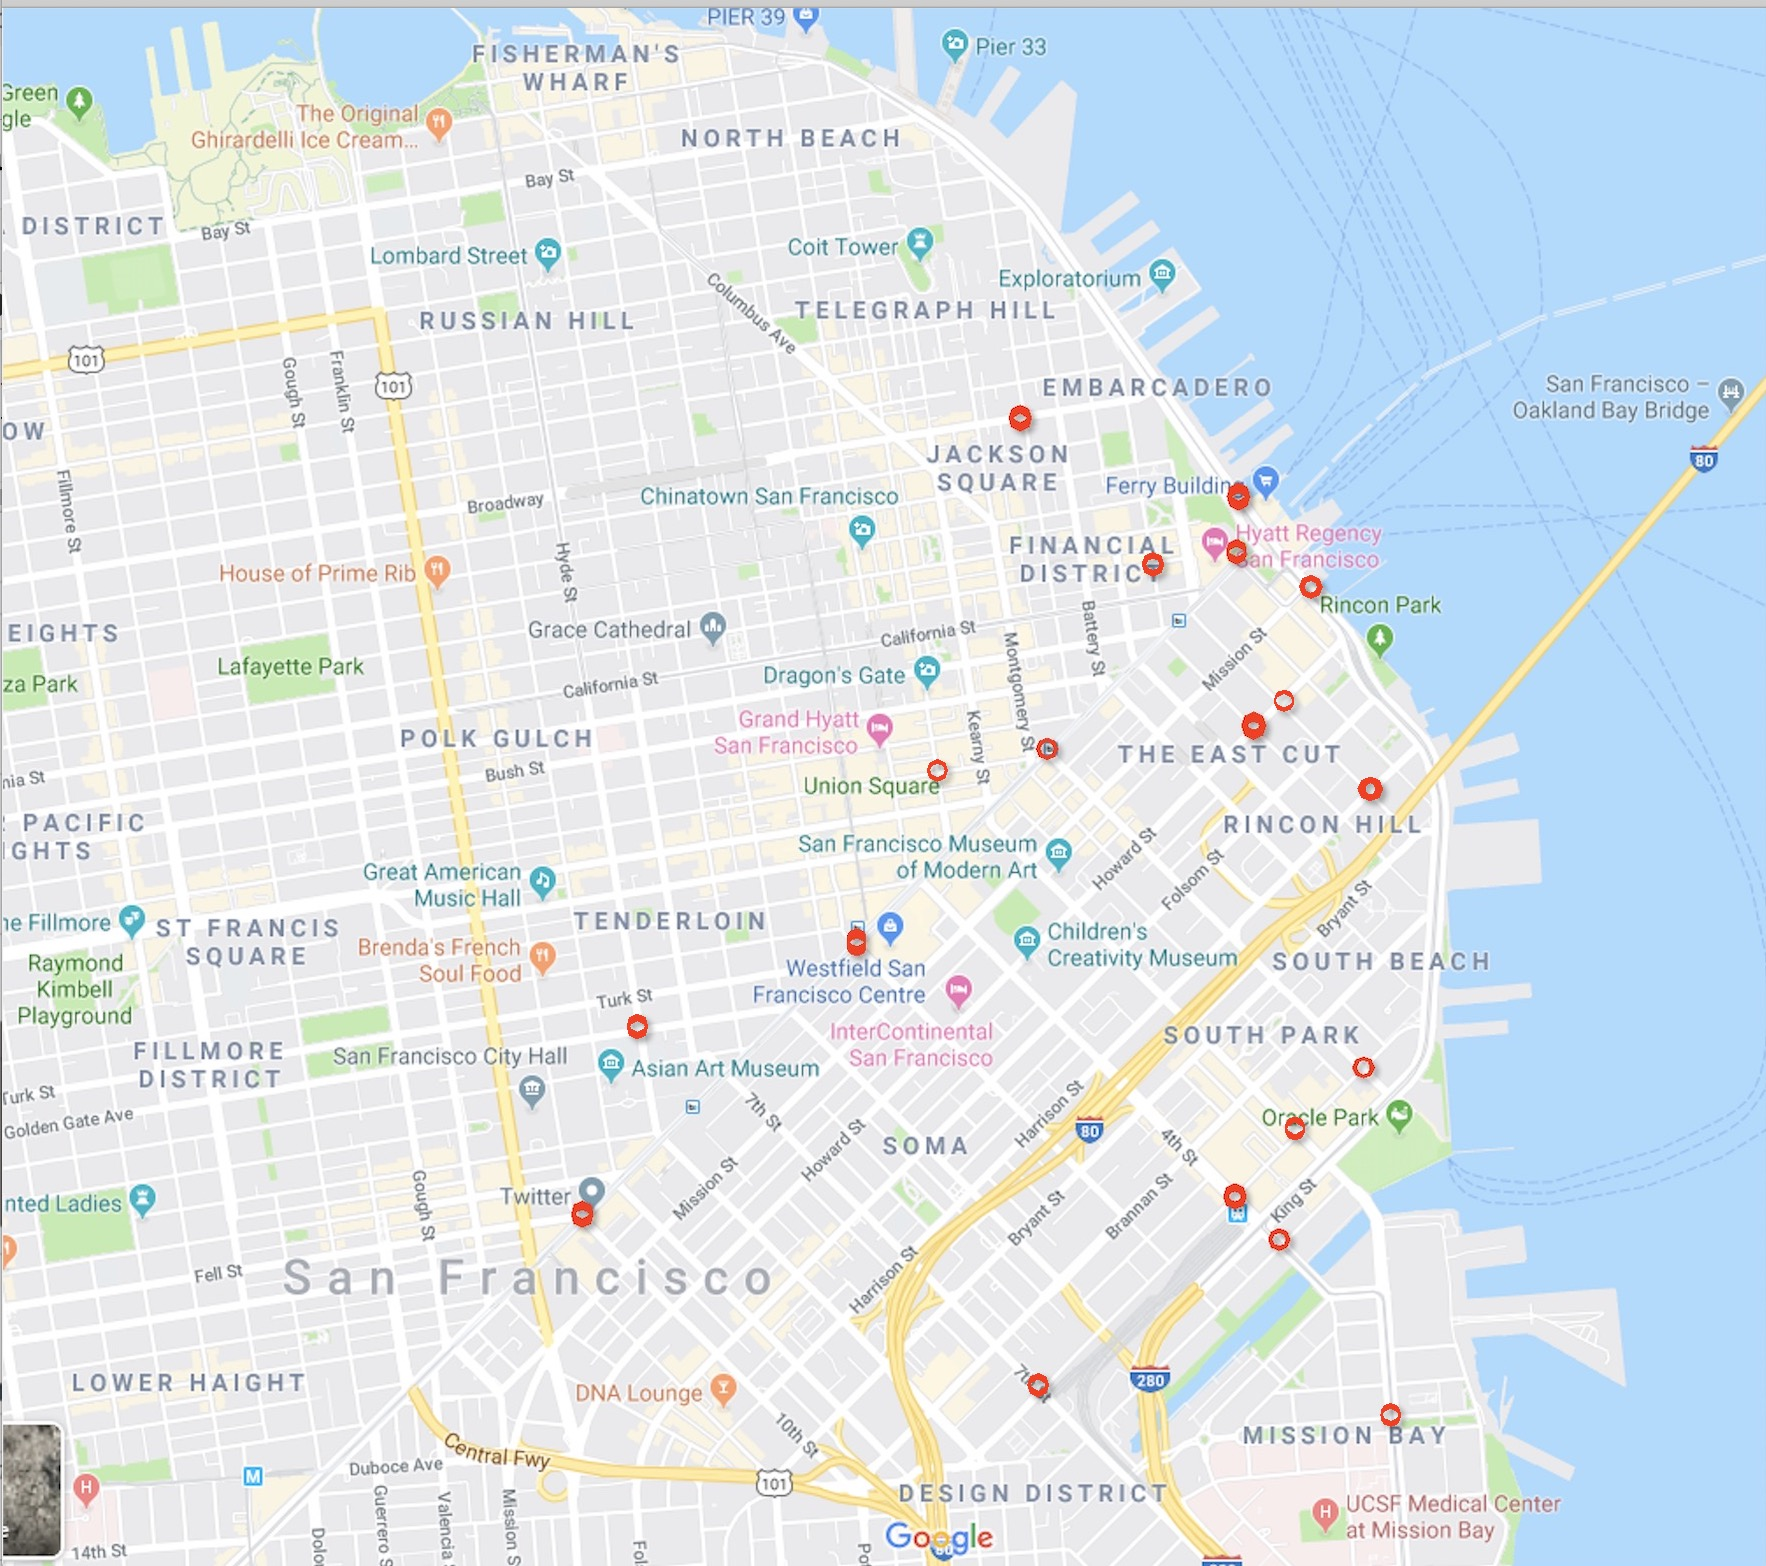